# Implementing DeepVelo in gastrulation erythroid maturation data

To compare cellDancer with other methods, this notebook shows the prediction of RNA velocity of [DeepVelo](https://www.biorxiv.org/content/10.1101/2022.04.03.486877v2) in gastrulation erythroid maturation. We select 12,329 cells with 2,000 genes from haemato-endothelial progenitors, blood progenitors 1/2, and erythroid 1/2/3. The embryonic days are selected from E7.0, E7.25, E7.5, E7.75, E8.0, E8.25, and E8.5. The selected cells with genes are the same as the datasets used in cellDancer. The input data could be downloaded from [GastrulationErythroid.h5ad](https:DentateGyrus.h5ad).

# Import packages

In [1]:
# %%
import numpy as np
import scvelo as scv
import torch
from umap import UMAP
from sklearn.decomposition import PCA
from scipy.stats import mannwhitneyu

from deepvelo.utils import velocity, velocity_confidence, update_dict
from deepvelo.utils.preprocess import autoset_coeff_s
from deepvelo.utils.plot import statplot, compare_plot
from deepvelo import train, Constants

import anndata as ann

from adata_to_df import adata_to_df
import os
import sys
import glob
import pandas as pd
import math
import matplotlib.pyplot as plt
import celldancer as cd
import celldancer.cdplt as cdplt
from celldancer.cdplt import colormap

# fix random seeds for reproducibility
SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.set_figure_params(
    "scvelo", transparent=False
)  # for beautified visualization

# Load gastrulation erythroid maturation data

In [2]:
adata=ann.read_h5ad('your_path/GastrulationErythroid.h5ad')

# DeepVelo

In [3]:
# specific configs to overide the default configs
configs = {
    "name": "DeepVelo", # name of the experiment
    "loss": {"args": {"coeff_s": autoset_coeff_s(adata)}},
    "trainer": {"verbosity": 0}, # increase verbosity to show training progress
    "arch":{"args":{"pred_unspliced":True}}, 
    "n_gpu":0, # enable to use CPU
}
configs = update_dict(Constants.default_configs, configs)

scv.pp.neighbors(adata)

# initial velocity
velocity(adata, mask_zero=False)

trainer = train(adata, configs)

scv.tl.velocity_graph(adata, n_jobs=10)

adata.write('your_path/GastrulationErythroid_pred_DeepVelo.h5ad')

The ratio of spliced reads is 94.8% (more than 85%). Suggest using coeff_s 1.0.
computing neighbors
    finished (0:00:10) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:03) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
building graph


INFO:train:Beginning training of DeepVelo ...


velo data shape: torch.Size([12329, 2000])
velo_mat shape: (12329, 2000)
--> added 'velocity' (adata.layers)
--> added 'velocity_unspliced' (adata.layers)
--> added 'cell_specific_beta' (adata.layers)
--> added 'cell_specific_gamma' (adata.layers)
--> added 'cell_specific_alpha' (adata.layers)
computing velocity graph (using 10/48 cores)


  0%|          | 0/12329 [00:00<?, ?cells/s]

    finished (0:00:21) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


# Visualize the phase portraits of sample genes

In [4]:
%%capture
adata=ann.read('your_path/GastrulationErythroid_pred_DeepVelo.h5ad')

# project the RNA velocity to vector fields in the embedding space. adata.layers['velocity_TSNE'] was added.
scv.pl.velocity_embedding(
    adata,
    basis="umap",
    arrow_length=6,
    arrow_size=1.2,
    dpi=150,
)

In [5]:
# transfer anndata to pandas dataframe
DeepVelo_esti_df_gastrulation=adata_to_df(adata,embed_para='X_umap',embed_pred_para='velocity_umap')
DeepVelo_esti_df_gastrulation

,gene_name,unsplice,splice,unsplice_predict,splice_predict,cellID,clusters,embedding1,embedding2,velocity1,velocity2
0,Sox17,0.000000,0.043971,0.027660,0.031990,cell_363,Blood progenitors 2,3.460521,15.574629,0.025660,0.006924
1,Sox17,0.000000,0.000000,0.040791,0.000000,cell_382,Blood progenitors 2,2.490433,14.971734,0.040863,0.017580
2,Sox17,0.000000,0.018161,0.038218,0.012875,cell_385,Blood progenitors 2,2.351203,15.267069,0.025554,0.020947
3,Sox17,0.000000,0.000000,-0.051276,0.000000,cell_393,Blood progenitors 2,5.899098,14.388825,0.045658,-0.015175
4,Sox17,0.000000,0.000000,-0.000026,0.000000,cell_398,Blood progenitors 2,4.823139,15.374831,0.040145,-0.007877
...,...,...,...,...,...,...,...,...,...,...,...
24657995,Gm47283,0.214961,1.145533,0.202244,2.668017,cell_139318,Erythroid3,8.032358,7.603037,-0.007174,0.051243
24657996,Gm47283,0.300111,1.072944,-0.198431,3.451484,cell_139321,Erythroid3,10.352904,6.446736,-0.001559,0.038432
24657997,Gm47283,0.292607,1.199875,-0.020145,3.126081,cell_139326,Erythroid3,9.464873,7.261099,-0.003836,0.043327
24657998,Gm47283,0.266031,1.114659,0.100049,3.021553,cell_139327,Erythroid3,9.990495,7.243880,-0.011929,0.053913


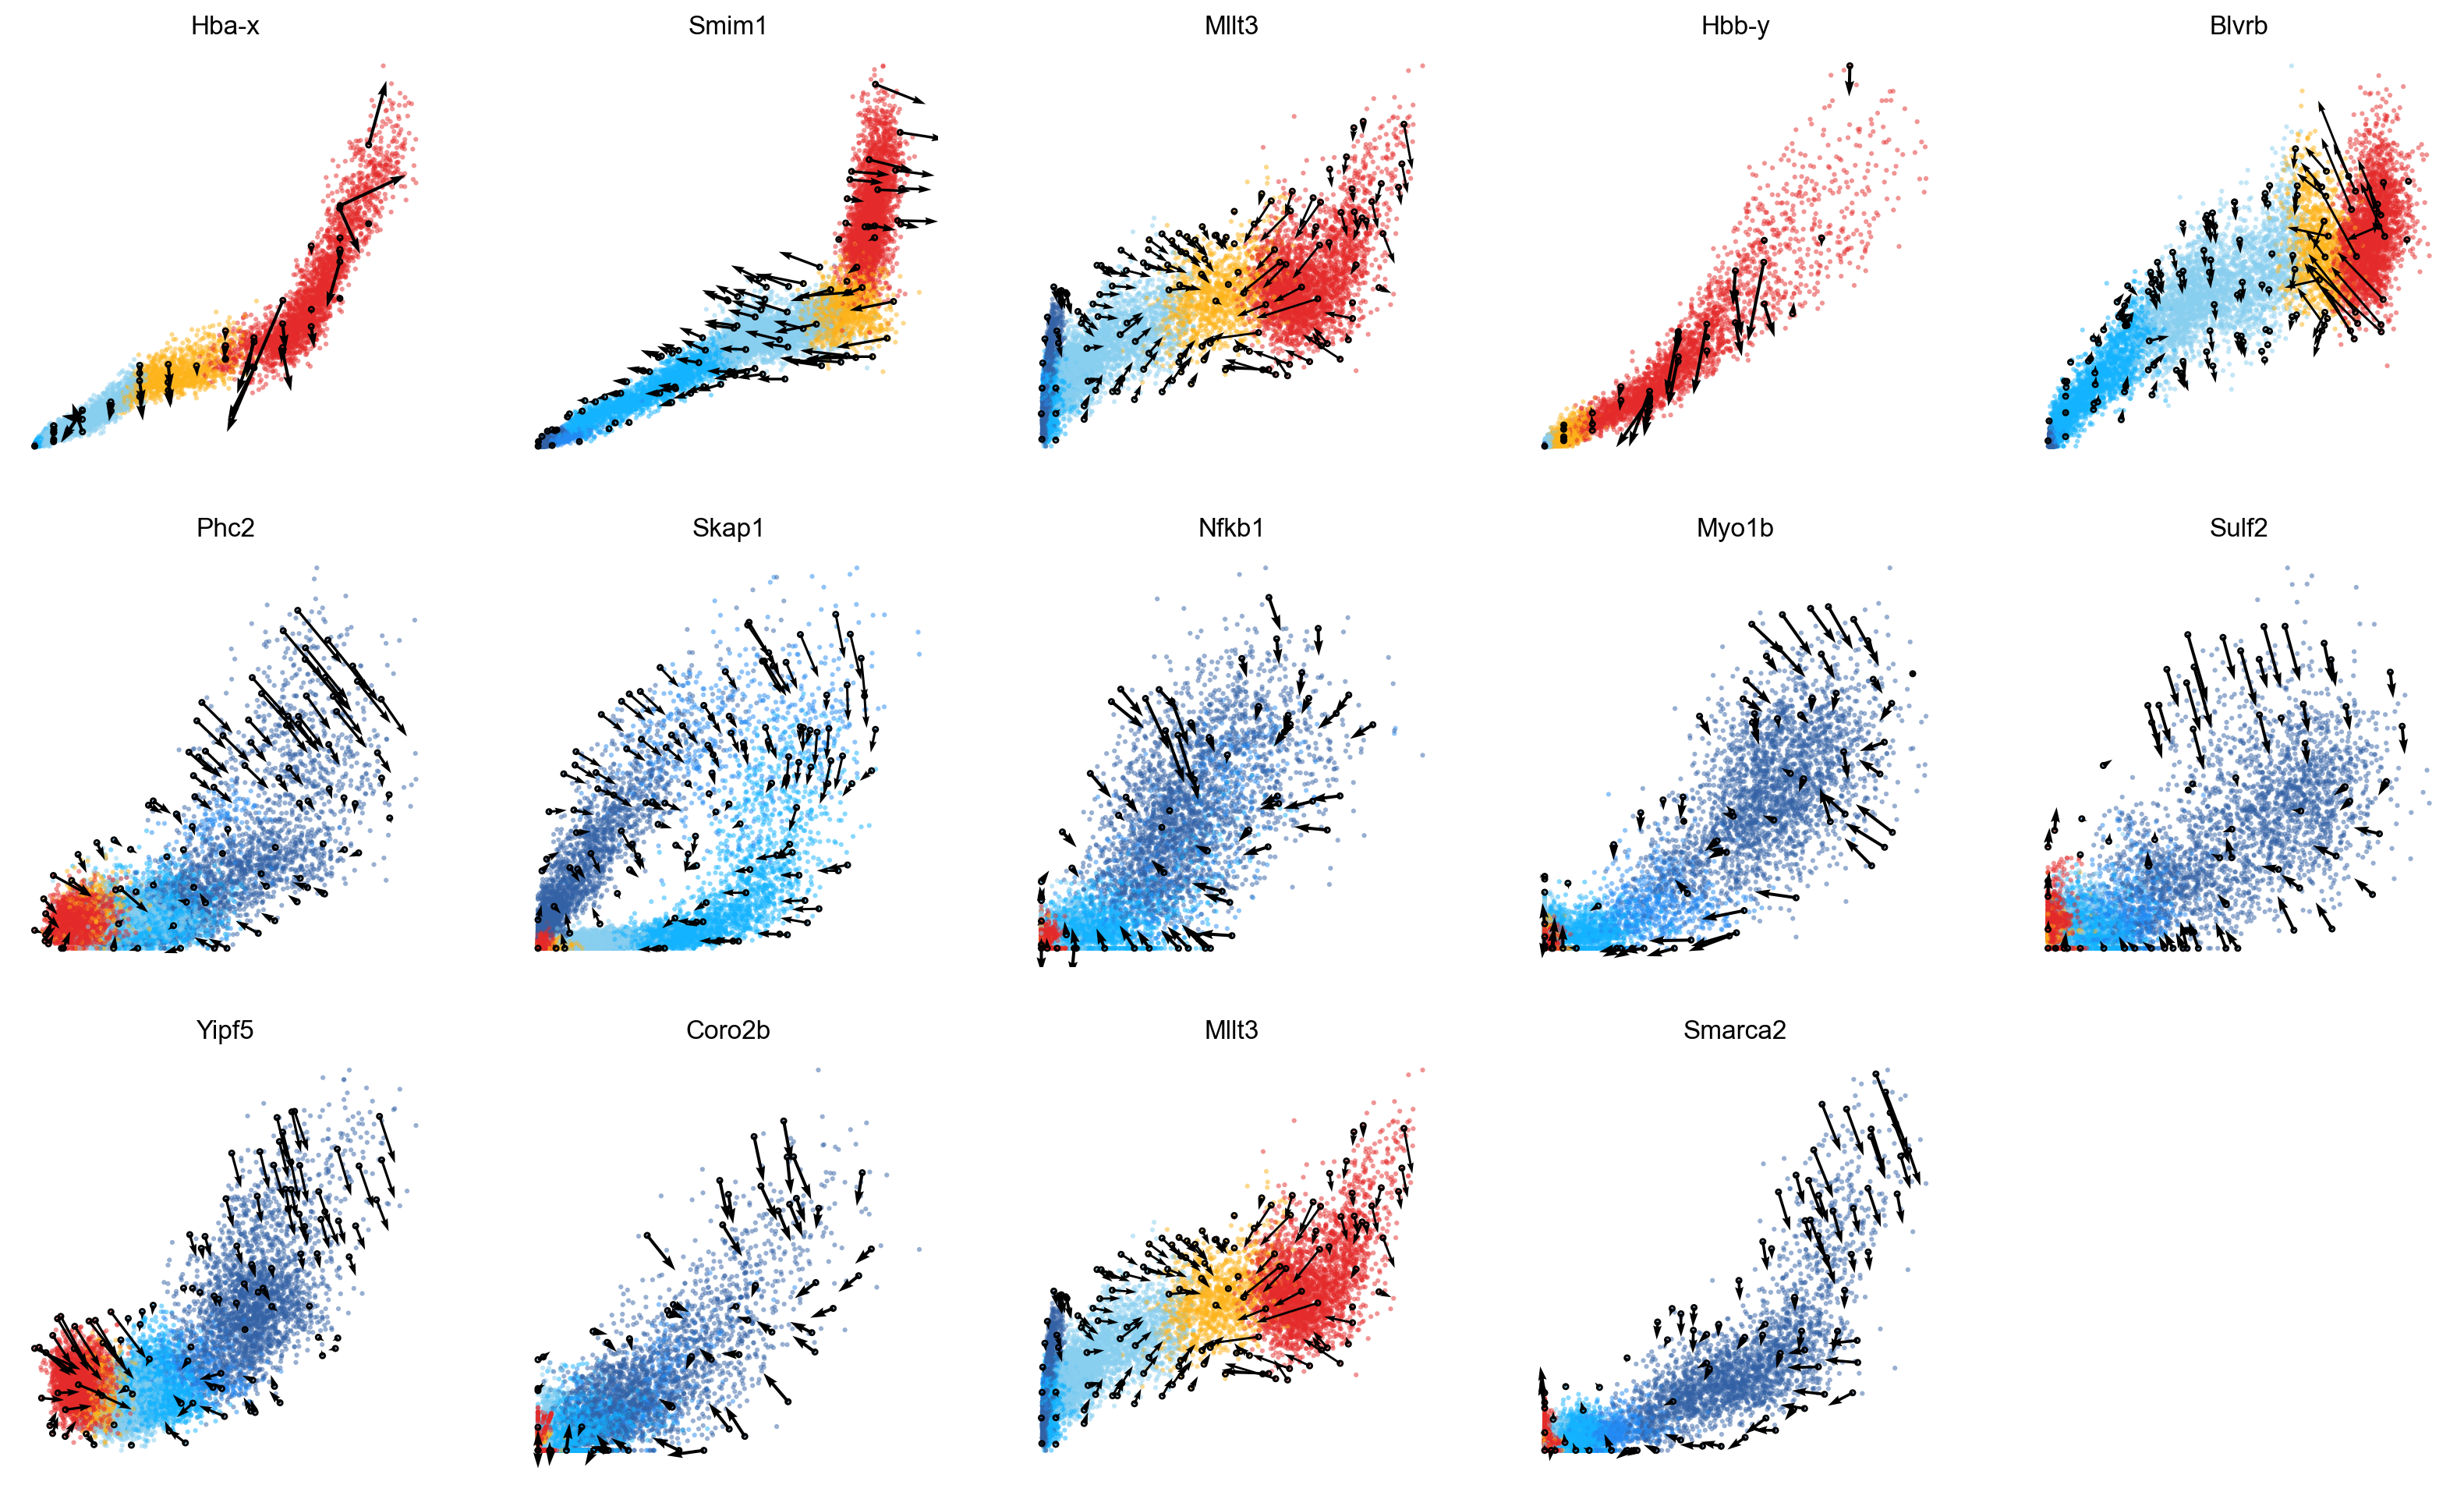

In [6]:
gene_list=['Hba-x','Smim1','Mllt3','Hbb-y','Blvrb','Phc2','Skap1','Nfkb1','Myo1b','Sulf2','Yipf5','Coro2b','Mllt3','Smarca2']

ncols=5
height=math.ceil(len(gene_list)/5)*4
fig = plt.figure(figsize=(20,height))

for i in range(len(gene_list)):
    ax = fig.add_subplot(math.ceil(len(gene_list)/ncols), ncols, i+1)
    cdplt.scatter_gene(
        ax=ax,
        x='splice',
        y='unsplice',
        cellDancer_df=DeepVelo_esti_df_gastrulation,
        custom_xlim=None,
        custom_ylim=None,
        colors=colormap.colormap_erythroid,
        alpha=0.5,
        s = 5,
        velocity=True,
        gene=gene_list[i])

    ax.set_title(gene_list[i])
    ax.axis('off')

plt.show()

# Project the RNA velocity to vector fields in the embedding space

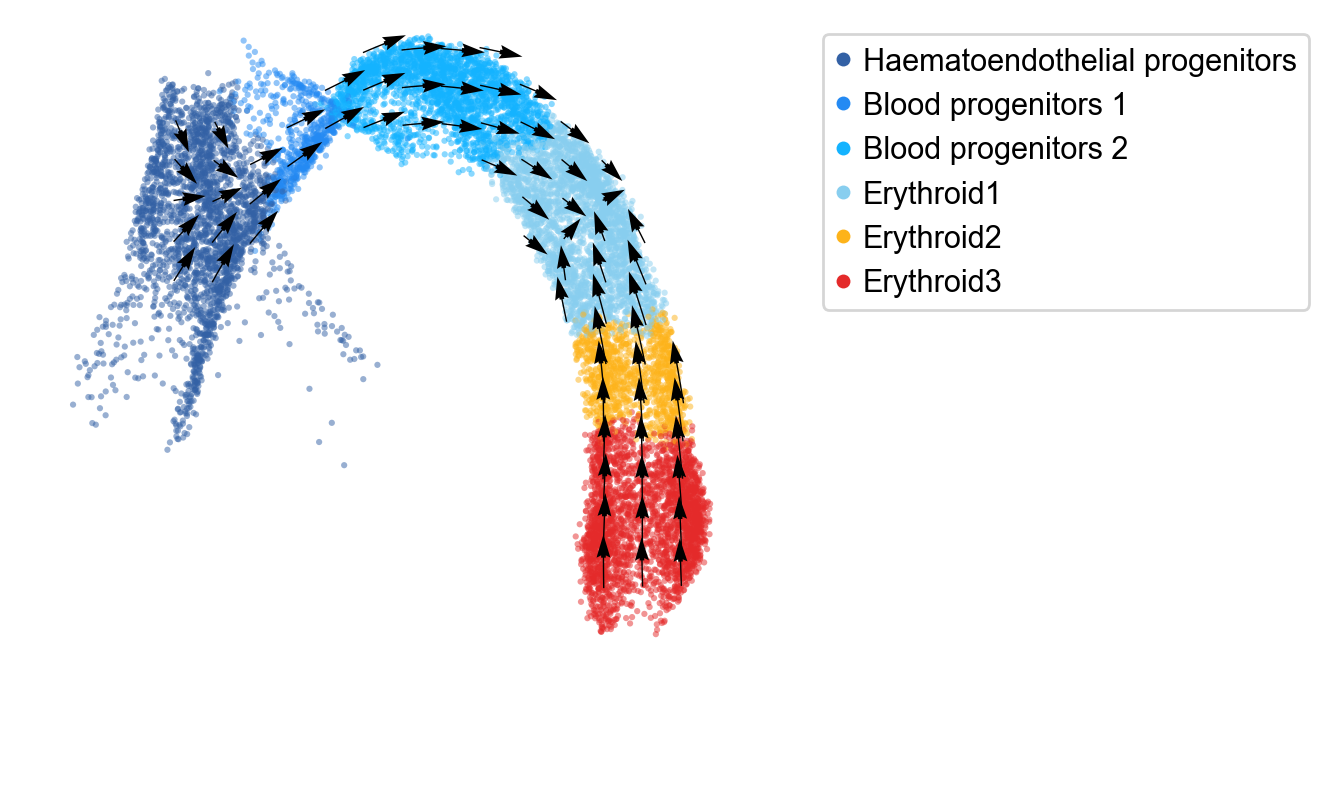

In [7]:
# plot cell velocity
fig, ax = plt.subplots(figsize=(5,5))
cdplt.scatter_cell(ax,
                   DeepVelo_esti_df_gastrulation,
                   colors=colormap.colormap_erythroid,
                   alpha=0.5,
                   s=5,
                   velocity=True,
                   legend='on',
                   min_mass=200,
                   arrow_grid=(20,40),
                   custom_xlim=[-6,13],
                   custom_ylim=[2,16])
ax.axis('off')
plt.show()

# Project the RNA velocity to vector fields in the embedding space for transcriptional boost genes

In [8]:
# murk genes
murk_genes=pd.read_csv('/Users/wanglab/Documents/ShengyuLi/Velocity/data/Gastrulation/MURK_genes/13059_2021_2414_MOESM3_ESM.csv')['index']
adata_murk=adata[:,adata.var_names.isin(murk_genes)]
adata_murk.var['velocity_genes']=True
scv.tl.velocity_graph(adata_murk, n_jobs=20)

computing velocity graph (using 20/48 cores)


  0%|          | 0/12329 [00:00<?, ?cells/s]

    finished (0:00:13) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [9]:
%%capture
# project the RNA velocity to vector fields in the embedding space. adata.layers['velocity_TSNE'] was added.
scv.pl.velocity_embedding(
    adata_murk,
    basis="umap",
    arrow_length=6,
    arrow_size=1.2,
    dpi=300,
)

In [10]:
# transfer anndata to pandas dataframe
DeepVelo_esti_df_gastrulation_murk=adata_to_df(adata_murk,embed_para='X_umap',embed_pred_para='velocity_umap')
DeepVelo_esti_df_gastrulation_murk

,gene_name,unsplice,splice,unsplice_predict,splice_predict,cellID,clusters,embedding1,embedding2,velocity1,velocity2
0,Mgst3,0.000000,0.119450,-0.067755,0.158383,cell_363,Blood progenitors 2,3.460521,15.574629,0.007373,-0.001017
1,Mgst3,0.000000,0.097280,-0.051480,0.133143,cell_382,Blood progenitors 2,2.490433,14.971734,0.030120,0.024560
2,Mgst3,0.000000,0.107186,-0.050680,0.144029,cell_385,Blood progenitors 2,2.351203,15.267069,0.039858,0.025886
3,Mgst3,0.000000,0.402772,-0.078134,0.468346,cell_393,Blood progenitors 2,5.899098,14.388825,-0.034642,0.027384
4,Mgst3,0.000000,0.202537,-0.079528,0.257415,cell_398,Blood progenitors 2,4.823139,15.374831,-0.016856,0.010075
...,...,...,...,...,...,...,...,...,...,...,...
752064,Alas2,0.054983,5.450834,0.034124,3.722094,cell_139318,Erythroid3,8.032358,7.603037,-0.002907,0.041065
752065,Alas2,0.036798,6.200462,0.085724,3.939886,cell_139321,Erythroid3,10.352904,6.446736,-0.001571,0.026560
752066,Alas2,0.031082,5.794872,0.084205,3.986576,cell_139326,Erythroid3,9.464873,7.261099,-0.018372,0.033299
752067,Alas2,0.026151,5.638885,0.109768,3.597783,cell_139327,Erythroid3,9.990495,7.243880,-0.009607,0.042930


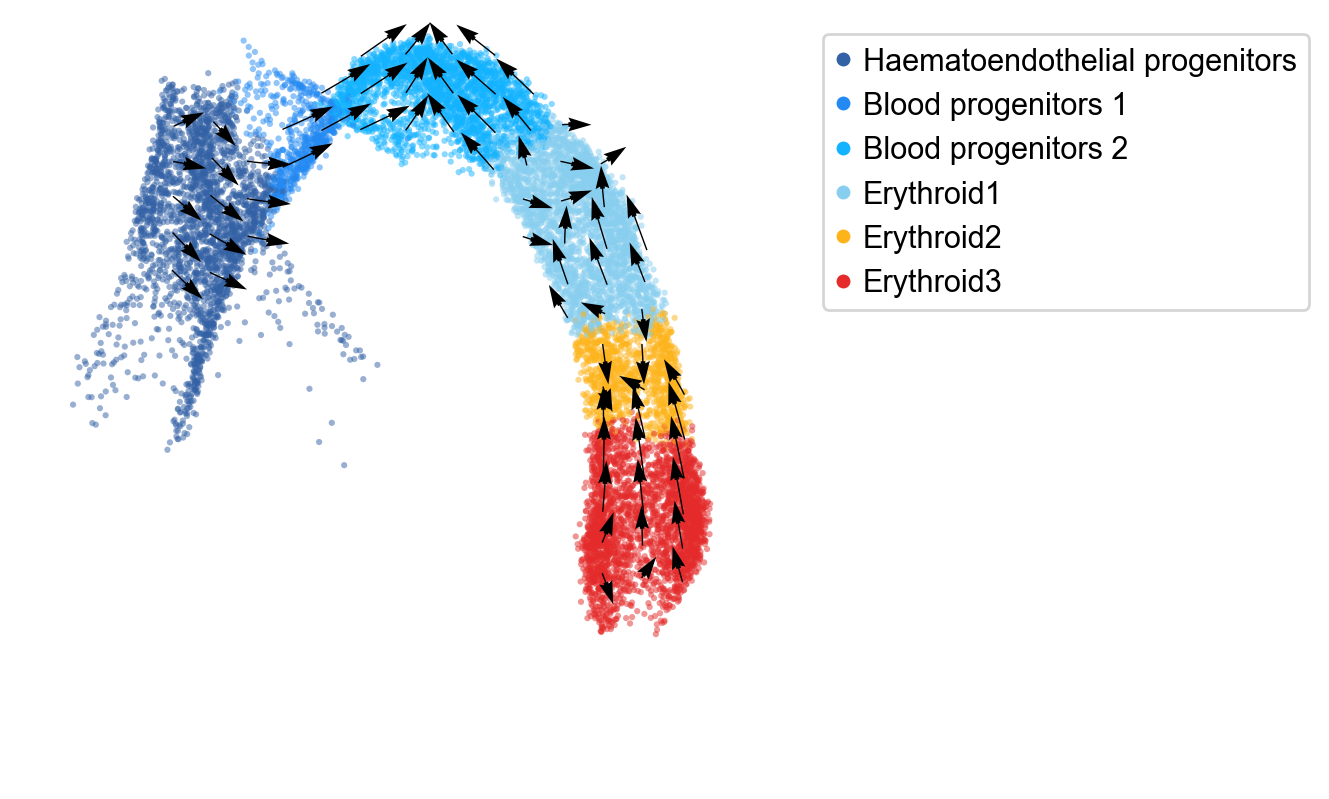

In [11]:
# plot cell velocity
fig, ax = plt.subplots(figsize=(5,5))
cdplt.scatter_cell(ax,
                   DeepVelo_esti_df_gastrulation_murk,
                   colors=colormap.colormap_erythroid,
                   alpha=0.5,
                   s=5,
                   velocity=True,
                   legend='on',
                   min_mass=200,
                   arrow_grid=(20,40),
                   custom_xlim=[-6,13],
                   custom_ylim=[2,16])
ax.axis('off')
plt.show()